In [31]:
import networkx as nx

# Path to local edge-list file
path = "web-Google.txt"

# Read into a directed graph
G = nx.read_edgelist(
    path,
    comments="#",            # ignore SNAP header lines
    delimiter="\t",          # tab-separated
    create_using=nx.DiGraph(),  # build a DiGraph
    nodetype=int             # cast node IDs to int
)

In [32]:
# Print basic info
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Nodes: 875713
Edges: 5105039


In [35]:
import statistics

# Compute PageRank
pr = nx.pagerank(G, alpha=0.85, tol=1e-6, max_iter=100)

target, orig_score = min(pr.items(), key=lambda kv: kv[1])
print(f"Baseline → node {target} has PageRank {orig_score:.6e}")

print(f"Out-degree of target: {G.out_degree(target)}")
print(f"In-degree of target: {G.in_degree(target)}")

Baseline → node 6 has PageRank 2.828111e-07
Out-degree of target: 3
In-degree of target: 0


In [38]:
max_node = max(pr, key=pr.get)
max_score = pr[max_node]
print(f"Node with max PageRank: {max_node} (score = {max_score:.6f})")

print(f"Out-degree of max_node: {G.out_degree(max_node)}")
print(f"In-degree of max_node: {G.in_degree(max_node)}")

Node with max PageRank: 163075 (score = 0.000952)
Out-degree of max_node: 36
In-degree of max_node: 4731


In [37]:
# Simulate a link-farm attack:
# Create 100 new nodes each pointing at target (node 6)
G_attack = G.copy()
max_id = max(G_attack.nodes())
new_nodes = list(range(max_id+1, max_id+1+1000))
for n in new_nodes:
    G_attack.add_edge(n, target)

In [39]:
pr_attack = nx.pagerank(G_attack, alpha=0.85, tol=1e-6, max_iter=100)
atk_score = pr_attack[target]
print(f"After attack → node {target} has PageRank {atk_score:.9f}")

After attack → node 6 has PageRank 0.000273794


In [43]:
max_node = max(pr_attack, key=pr_attack.get)
max_score = pr[max_node]
print(f"Node with max PageRank: {max_node} (score = {max_score:.6f})")

Node with max PageRank: 163075 (score = 0.000952)


In [41]:
in_thresh=0  # max in-degree to consider “spammy”
out_thresh=1  # max out-degree to consider “spammy”
# find spam nodes
spam_nodes = [
        u for u in G_attack.nodes()
        if G_attack.in_degree(u) <= in_thresh
           and 1 <= G_attack.out_degree(u) <= out_thresh
    ]
len(spam_nodes)  # number of spam nodes

38564

# Case 1: Removing spam edges

In [49]:
# Remove the spam‐to‐victim edges entirely
G_prune = G_attack.copy()
edges_to_remove = [
    (u, v) for u in spam_nodes for v in G_attack.successors(u)
]
G_prune.remove_edges_from(edges_to_remove)

# 2. Recompute ordinary PageRank
pr_prune = nx.pagerank(G_prune, alpha=0.85, tol=1e-6, max_iter=100)

Before defense → PR[6] = 2.737939e-04
After weighted defense → PR[6] = 3.644251e-07


In [51]:
print(f"Before defense → PR[{target}] = {pr_attack[target]:.9f}")
print(f"After weighted defense → PR[{target}] = {pr_prune[target]:.9f}")

Before defense → PR[6] = 0.000273794
After weighted defense → PR[6] = 0.000000364


In [73]:
nodes = list(pr.keys())

# Compute differences
delta_attack = [pr_attack[n] - pr[n] for n in nodes]
delta_prune  = [pr_prune[n]  - pr[n] for n in nodes]

# How many nodes gained rank in the attack?
gain_count = sum(1 for d in delta_attack if d > 0)
# How many lost rank when we pruned?
loss_count = sum(1 for n in nodes if pr_prune[n] < pr_attack[n])

print(f"{gain_count}/{len(nodes)} nodes gained PageRank in the attack")
print(f"{loss_count}/{len(nodes)} nodes lost PageRank after pruning")

4/875713 nodes gained PageRank in the attack
239975/875713 nodes lost PageRank after pruning


# Case 2: Decrease Page Rank by percentage deduction from Penalty

In [60]:
# Compute penalty
penalty = {v: 0.0 for v in G_attack}
for u in spam_nodes:
    contrib = pr_attack[u] / G_attack.out_degree(u)
    for v in G_attack.successors(u):
        penalty[v] += contrib

Node 6: penalty = 0.000282339
Node 916308: penalty = 0.000113782
Node 722083: penalty = 0.000097125
Node 913197: penalty = 0.000089784
Node 909067: penalty = 0.000073973
Node 244888: penalty = 0.000073973
Node 819223: penalty = 0.000073126
Node 495084: penalty = 0.000070585
Node 901769: penalty = 0.000067761
Node 36292: penalty = 0.000055903


In [68]:
penalty_pct = {
    v: (penalty[v] / pr_attack[v] * 100) if pr_attack[v] > 0 else 0.0
    for v in penalty
}

# 2) Extract the top 2 nodes by this percentage:
top2 = sorted(
    penalty_pct.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:10]

# 3) Print them:
for node, pct in top2:
    print(f"Node {node}: {pct:.2f}% of its PageRank came from spam")

Node 6: 103.12% of its PageRank came from spam
Node 916308: 102.96% of its PageRank came from spam
Node 913197: 102.89% of its PageRank came from spam
Node 916055: 102.07% of its PageRank came from spam
Node 908570: 101.45% of its PageRank came from spam
Node 908310: 101.33% of its PageRank came from spam
Node 901519: 100.76% of its PageRank came from spam
Node 909342: 100.66% of its PageRank came from spam
Node 853709: 100.57% of its PageRank came from spam
Node 901219: 100.51% of its PageRank came from spam


In [72]:
# Compute final PageRank by deducting the spam percentage
final_pr = {
    v: max(pr_attack[v] * (1 - (penalty_pct.get(v, 0) / 100)), 0)
    for v in pr_attack
}

# Find the node with the highest adjusted PageRank
node_max, pr_max = max(final_pr.items(), key=lambda kv: kv[1])
# Find the node with the lowest adjusted PageRank
node_min, pr_min = min(final_pr.items(), key=lambda kv: kv[1])

print(f"Node with max adjusted PR: {node_max} (PR = {pr_max:.9f})")
print(f"Node with min adjusted PR: {node_min} (PR = {pr_min:.9f})")

Node with max adjusted PR: 163075 (PR = 0.000938128)
Node with min adjusted PR: 6 (PR = 0.000000000)


In [75]:
# Determine the top 20% nodes by baseline PageRank
n = len(pr)
top20_n = int(n * 0.20)
top20 = sorted(pr, key=pr.get, reverse=True)[:top20_n]

# 2) Compute average PR over that subset
avg_baseline = sum(pr[v]        for v in top20) / top20_n
avg_attack   = sum(pr_attack[v] for v in top20) / top20_n
avg_prune    = sum(pr_prune[v]  for v in top20) / top20_n
avg_final    = sum(final_pr[v]  for v in top20) / top20_n

print("Top 20 % nodes average PR:")
print(f"  Baseline : {avg_baseline:.9f}")
print(f"  Attack   : {avg_attack:.9f}")
print(f"  Prune    : {avg_prune:.9f}")
print(f"  Reduction: {avg_final:.9f}")

Top 20 % nodes average PR:
  Baseline : 0.000003692
  Attack   : 0.000003689
  Prune    : 0.000003352
  Reduction: 0.000003635


In [76]:
# Determine top 20% baseline nodes
n = len(pr)
top_n = int(n * 0.20)
baseline_top20 = set(sorted(pr, key=pr.get, reverse=True)[:top_n])

# Determine top 20% nodes at each stage
attack_top20    = set(sorted(pr_attack, key=pr_attack.get, reverse=True)[:top_n])
prune_top20     = set(sorted(pr_prune,  key=pr_prune.get,  reverse=True)[:top_n])
reduction_top20 = set(sorted(final_pr,   key=final_pr.get,   reverse=True)[:top_n])

# Compute how many baseline top-20% nodes stayed in the top 20% at each stage
attack_preserved    = len(baseline_top20 & attack_top20)
prune_preserved     = len(baseline_top20 & prune_top20)
reduction_preserved = len(baseline_top20 & reduction_top20)

print(f"Baseline top 20% size: {top_n}")
print(f"Preserved after attack:   {attack_preserved}/{top_n}")
print(f"Preserved after pruning:  {prune_preserved}/{top_n}")
print(f"Preserved after reduction: {reduction_preserved}/{top_n}")

Baseline top 20% size: 175142
Preserved after attack:   175137/175142
Preserved after pruning:  140110/175142
Preserved after reduction: 173674/175142


## Visualizing the effects

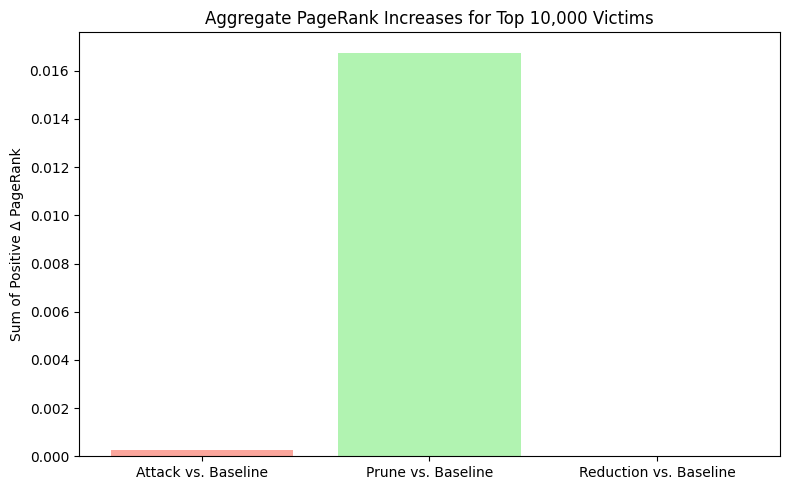

In [115]:
import matplotlib.pyplot as plt

# Identify top 10,000 victim nodes by penalty
victims = sorted(
    (v for v, pen in penalty.items() if pen > 0),
    key=lambda v: penalty[v],
    reverse=True
)[:10000]

# Gather PageRank values
baseline_vals  = [pr[v]         for v in victims]
attack_vals    = [pr_attack[v]  for v in victims]
prune_vals     = [pr_prune[v]   for v in victims]
reduction_vals = [final_pr[v]   for v in victims]

# Compute non-negative differences and their sums
sum_diff_attack    = sum(max(attack_vals[i]    - baseline_vals[i], 0) for i in range(len(victims)))
sum_diff_prune     = sum(max(prune_vals[i]     - baseline_vals[i], 0) for i in range(len(victims)))
sum_diff_reduction = sum(max(reduction_vals[i] - baseline_vals[i], 0) for i in range(len(victims)))

# Plot single bar chart
labels = ['Attack vs. Baseline', 'Prune vs. Baseline', 'Reduction vs. Baseline']
values = [sum_diff_attack, sum_diff_prune, sum_diff_reduction]
colors = ['salmon', 'lightgreen', 'orange']

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors, alpha=0.7)
plt.ylabel('Sum of Positive Δ PageRank')
plt.title('Aggregate PageRank Increases for Top 10,000 Victims')
plt.tight_layout()
plt.show()